
#Sistema automático para la detección de COVID-19 en radiografías#



Una de las aplicaciones de AI es el procesamiendo de imágenes médicas. En particular, el uso de radiografías para una detección no invasiva y rápida del Covid-19 puede resultar extremadamente útil para ayudar y agilizar la tarea del personal médico [1][2].

En este proyecto desarrollaremos un detector *Deep Learning* de Covid-19 en radiografías. Para ello, utilizaremos las imágeners de la base de datos "Covid-chestxray-dataset" [3], generada por unos investigadores del grupo de investigación [Mila](https://mila.quebec/en/) y de la Universidad de Montreal [4]. También utilizaremos imágenes de radiografías de pacientes sanos y con neumonía bacterial extraídas de la competición de Kaggle "Chest X-Ray Images (Pneumonia)" [5].

En total, disponemos de una cantidad de 426 imágenes, divididas en conjuntos de entrenamiento (339 imágenes), validación (42 imágenes) y test (45 imágenes).

Las particiones se dan en listas ".txt", en las que a cada imagen se le asigna una etiqueta:
- 0) Healthy
- 1) Covid-19
- 2) Pneumonia

El objetivo consisten en desarrollar un sistema basado en redes neuronales capaz de clasificar correctamente las imágenes en estas 3 categorías.


#### Referencias
1. María Climent, 2020 [Covid-19: La Inteligencia Artificial De La Española Quibim Puede Acelerar El Diagnóstico Del Coronavirus](https://innovadores.larazon.es/es/esta-inteligencia-artificial-espanola-puede-acelerar-el-diagnostico-del-coronavirus/)
2. Angel Alberich-bayarri,2020 [Imagin, AI and Radiomix to understand and fight Coronavirus Covid-19](https://quibim.com/2020/02/14/imaging-ai-and-radiomics-to-understand-and-fight-coronavirus-covid-19/)
3. [Ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)
4. Cohen, J.P., Morrison, P. and Dao, L., 2020. [COVID-19 image data collection](https://arxiv.org/pdf/2003.11597.pdf).
5. Paul Mooney, 2019 [Chest X-ray Images (pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


#### Lecturas recomendadas
6. Souradip Chakraborty, 2020. [Detection Of Covid-19 Presence from Chest X-ray Scans Using Cnn & Class Activation Maps](https://towardsdatascience.com/detection-of-covid-19-presence-from-chest-x-ray-scans-using-cnn-class-activation-maps-c1ab0d7c294b)

7. Cohen, J.P., Hashir, M., Brooks, R. and Bertrand, H., 2020. [On the limits of cross-domain generalization in automated X-ray prediction](https://arxiv.org/pdf/2002.02497.pdf)

8. Karim, M., Döhmen, T., Rebholz-Schuhmann, D., Decker, S., Cochez, M. and Beyan, O., 2020. [Deepcovidexplainer: Explainable covid-19 predictions based on chest x-ray images](https://arxiv.org/pdf/2004.04582.pdf).

9. Wang, L., Wong, A. (2020). [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest Radiography Images](https://arxiv.org/abs/2003.09871)

10. Zhou, B., Khosla, A., Lapedriza, A., Oliva, A. and Torralba, A., 2016. [Learning deep features for discriminative localization](https://arxiv.org/pdf/1512.04150.pdf). In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2921-2929).

11. Mordvintsev, A., Olah, C. and Tyka, M., 2015. [Inceptionism: Going deeper into neural networks](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html).

# Preparación del Dataset

En este primer apartado se analizarán las imágenes de la base de datos y se diseñará un *pipeline* para cargar las imágenes y prepararlas para la red neuronal.

Se deberán tener en cuenta factores como:
- Tamaño de entrada de las imágenes
- Normalización de las imágenes
- Visualizaciones de algunas muestras de cada categoría
- Técnicas de *data augmentation* para aumentar el tamaño del conjunto de entrenamiento

Y, en general, cualquier técnica que consideréis que pueda mejorar la implementación y resultados de este proyecto.

In [1]:
# importe librerias necesarias
import cv2
import matplotlib.pyplot as plt
import imageio
import os
import random

#Empece con este codigo que al final no la utilice.
'''def visualizar_muestras(directorio_datos):
        categorias = os.listdir(directorio_datos)
        fig, axs = plt.subplots(1, len(categorias), figsize=(15, 5))
        for i, categoria in enumerate(categorias):
                ruta_categoria = os.path.join(directorio_datos, categoria)
                imagenes = os.listdir(ruta_categoria)
                imagen_aleatoria = random.choice(imagenes)
                ruta_imagen = os.path.join(ruta_categoria, imagen_aleatoria)
                imagen = cv2.imread(ruta_imagen)
                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) #convierte la imagen a RGB.
                axs[i].imshow(imagen)
                axs[i].set_title(categoria)
                axs[i].axis('off')
plt.show()

visualizar_muestras('C:/Users/claua/Documents/Redes neuronales/Proyecto/Datos trabajo final/Data')'''

"def visualizar_muestras(directorio_datos):\n        categorias = os.listdir(directorio_datos)\n        fig, axs = plt.subplots(1, len(categorias), figsize=(15, 5))\n        for i, categoria in enumerate(categorias):\n                ruta_categoria = os.path.join(directorio_datos, categoria)\n                imagenes = os.listdir(ruta_categoria)\n                imagen_aleatoria = random.choice(imagenes)\n                ruta_imagen = os.path.join(ruta_categoria, imagen_aleatoria)\n                imagen = cv2.imread(ruta_imagen)\n                imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) #convierte la imagen a RGB.\n                axs[i].imshow(imagen)\n                axs[i].set_title(categoria)\n                axs[i].axis('off')\nplt.show()\n\nvisualizar_muestras('C:/Users/claua/Documents/Redes neuronales/Proyecto/Datos trabajo final/Data')"

In [2]:
#Importe mas librerias
import glob
from skimage.transform import resize
import numpy as np
import os

#El ajuste de la imagen sufrieron muchos cambios, empece con 200, 200, 3, 
#pero no me generaba casi nada porque no veia mucho detalle, subi a 512, mejoraba pero no mucho
#subi a 768, con la ANN iba bien pero nunca lograba una linea de curva de entrenamiento que sea mas baja que la de test y 
#cuando quise implementar la CNN con esta resolucion de imagen el ordenador casi muere, termine dejandolo en 640.

TARGET_SIZE = (640, 640, 3)
PORCION_TRAIN = 0.8

def contar_imagenes(directorio_datos):
    categorias = os.listdir(directorio_datos)
    total_imagenes = 0
    for categoria in categorias:
        ruta_categoria = os.path.join(directorio_datos, categoria)
        imagenes = os.listdir(ruta_categoria)
        num_imagenes = len(imagenes)
        print(f"Categoría {categoria}: {num_imagenes} imágenes")
        total_imagenes += num_imagenes
    print(f"Total de imágenes: {total_imagenes}")

contar_imagenes('Datos trabajo final/Data')

#Genere un contador para saber cuantas imagenes habia en cada carpeta.

Categoría dataset_COVID-19: 142 imágenes
Categoría dataset_HEALTHY: 142 imágenes
Categoría dataset_PNEUMONIA: 142 imágenes
Total de imágenes: 426


In [3]:
def nueva_funcion(IMAGENES_RUTA, TARGET_SIZE, estado):
    ruta_archivoC = []
    imagenes = []
    resultado = []
    extenciones = ['*.jpeg', '*.jpg', '*.png']
    for ext in extenciones:
        ruta_archivoC = glob.glob(os.path.join(IMAGENES_RUTA, ext))
        for path in ruta_archivoC:
            try:
                img = cv2.imread(path)
                resized_img = resize(img, TARGET_SIZE, anti_aliasing=True)
                imagenes.append(resized_img)
                resultado.append(estado)
            except Exception as e:
                print(f"Error processing {path}: {e}")

    imagenes = np.asarray(imagenes)
    resultado = np.asarray(resultado) 
    print('Total imagenes: ' + str(len(imagenes)))
    print("Images shape: ", imagenes.shape) #print the resulting shape.
    return imagenes, resultado

IMAGENES_RUTA_CO = "Datos trabajo final/Data/dataset_COVID-19"

imagenesCO, resultadoCO = nueva_funcion(IMAGENES_RUTA_CO, TARGET_SIZE, [1,0,0])

IMAGENES_RUTA_P = "Datos trabajo final/Data/dataset_PNEUMONIA"

imagenesP, resultadoP = nueva_funcion(IMAGENES_RUTA_P, TARGET_SIZE, [0,1,0])

IMAGENES_RUTA_H = "Datos trabajo final/Data/dataset_HEALTHY" 

imagenesH, resultadoH = nueva_funcion(IMAGENES_RUTA_H, TARGET_SIZE, [0,0,1])

#Aca realice la lectura de imagenes por cada carpeta, en donde preparo un conjunto de datos de imágenes para un 
# modelo de clasificación de imágenes. Carga imágenes de tres categorías diferentes, las redimensiona a un tamaño uniforme y 
# las etiqueta con vectores one-hot. El resultado son tres conjuntos de datos (imágenes y etiquetas) que se pueden usar para 
# entrenar una red neuronal, lo hice de esta manera en que cree la funcion porque antes estaba repitiendo el codigo 3 veces, 
# hice tambien una extencion porque una de las carpetas tenia mas de un formato.

Total imagenes: 142
Images shape:  (142, 640, 640, 3)
Total imagenes: 142
Images shape:  (142, 640, 640, 3)
Total imagenes: 142
Images shape:  (142, 640, 640, 3)


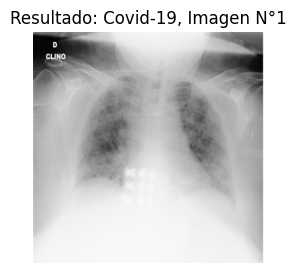

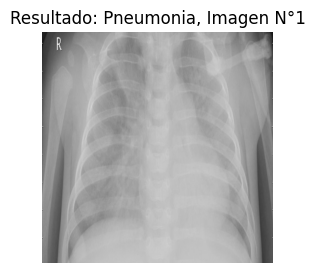

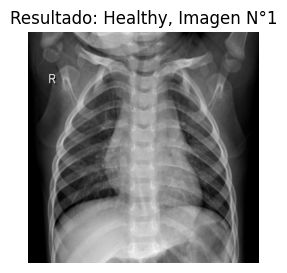

In [4]:
def validar_imagenes(imagenes, results, num_imagenes_mostrar=1):
    for indice in range(num_imagenes_mostrar):
        result_map = {'[0 0 1]': 'Healthy','[1 0 0]': 'Covid-19','[0 1 0]': 'Pneumonia',}
        plt.figure(figsize=(3,3))
        plt.imshow(imagenes[indice])
        enfermedad= str(results[indice])
        plt.title(f"Resultado: {result_map[enfermedad]}, Imagen N°{indice+1}")
        plt.axis('off')
        plt.show()

validar_imagenes(imagenesCO, resultadoCO)
validar_imagenes(imagenesP, resultadoP)
validar_imagenes(imagenesH, resultadoH)

#Genere un codigo para visualizar imágenes de un conjunto de datos junto con sus etiquetas de clasificación. 
#para yo poder verificar que las imágenes se hayan cargado y etiquetado correctamente.

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#importe más librerias 

In [6]:
def funcion(resultado, porcion_train, train=[], test= []):
    resultado= tuple(resultado)
    train=list(train)
    test=list(test)
    por=0
    for i in resultado:
        porcent = porcion_train*len(resultado)
        if por < porcent:
            train.append(i)
        else:
            test.append(i)
        por+=1
    
    train= np.asarray(train)
    test= np.asarray(test)
    return train, test

x_train, x_test = funcion(imagenesCO, PORCION_TRAIN)
x_train, x_test = funcion(imagenesP, PORCION_TRAIN, x_train, x_test)
x_train, x_test = funcion(imagenesH, PORCION_TRAIN, x_train, x_test)

y_train, y_test = funcion(resultadoCO, PORCION_TRAIN)
y_train, y_test = funcion(resultadoP, PORCION_TRAIN, y_train, y_test)
y_train, y_test = funcion(resultadoH, PORCION_TRAIN, y_train, y_test)

#Dividi los datos de imagenes y etiquetas en conjuntos de entrenamiento y prueba, para cada clase, covid, pneumonia y saludable, 
#para poder entrenar el modelo, el codigo acumula los datos de las 3 clases en un solo set de train y test.


In [7]:
BATCH_SIZE = 24

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normaliza los píxeles a [0,1]
    rotation_range=20,         # Rotación aleatoria hasta 20 grados
    width_shift_range=0.2,     # Desplazamiento horizontal
    height_shift_range=0.2,    # Desplazamiento vertical
    shear_range=0.2,           # Cizallamiento
    zoom_range=0.2,            # Zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal
    fill_mode='nearest'
)

# Para el conjunto de test solo se aplica rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores usando la estructura de carpetas
train_generator = train_datagen.flow(

    x= x_train,
    y= y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_datagen.flow(

    x= x_test,
    y= y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#Este código prepara los datos para el entrenamiento y la prueba de un modelo de clasificación de imágenes. 
# El generador de entrenamiento aplica aumentación de datos para aumentar la diversidad del conjunto de entrenamiento y 
# mejorar la generalización del modelo. El generador de prueba solo normaliza los datos de prueba. 
# Ambos generadores producen lotes de imágenes y etiquetas que se pueden usar para entrenar y evaluar el modelo.


In [8]:
model_ann = Sequential([
    Flatten(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2])),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(128),#, activation='LeakyReLU'),
    LeakyReLU(),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(128),#, activation='LeakyReLU'),
    LeakyReLU(),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(3, activation='sigmoid')
])
model_ann.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
model_ann.summary()

#Luego de hacer varias pruebas modificando los valores de la ANN, decidi quitar los Dropout comentandolos y 
#la mejor grafica que obtuve es la representada más abajo en donde se ve que la linea de curva del 
#entrenamiento está por debajo de la de testing, aplique la LeakyReLU y antes solo estaba usando relu para todas las capas.

C:\Users\cesar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1228800)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   157,286,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,338,499 (600.20 MB)

 Trainable params: 157,337,475 (600.19 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [9]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
EPOCHS = 20 #Ajusta el número de épocas según sea necesario

history_ann = model_ann.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

#Asigen las epocas, una paciencia de 5, el historial se guarda para luego poder graficar.

C:\Users\cesar\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - categorical_accuracy: 0.4856 - loss: 1.3417 - val_categorical_accuracy: 0.4167 - val_loss: 1.0875
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - categorical_accuracy: 0.6180 - loss: 0.8082 - val_categorical_accuracy: 0.6310 - val_loss: 1.0749
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - categorical_accuracy: 0.6376 - loss: 0.7000 - val_categorical_accuracy: 0.6071 - val_loss: 1.0534
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - categorical_accuracy: 0.6417 - loss: 0.8388 - val_categorical_accuracy: 0.5119 - val_loss: 1.0418
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - categorical_accuracy: 0.6650 - loss: 0.7684 - val_categorical_accuracy: 0.4762 - val_loss: 1.0291
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - categorical_accuracy: 0.6976 - loss: 0.6766 - val_categorical_accuracy: 0.5595 - val_loss: 1.0455
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - categorical_accuracy: 0.7167 - loss: 0.6166 - va

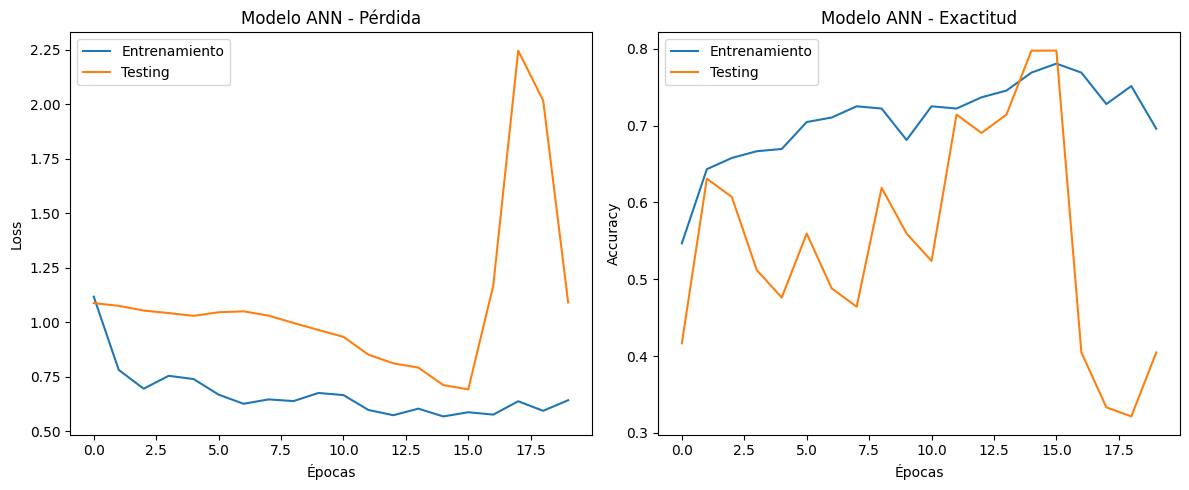

Modelo ANN - Pérdida: 0.6918, Exactitud: 0.7976


In [10]:
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12,5))
    # Curva de pérdida
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Testing')
    plt.title(f'{title_prefix} - Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    # Curva de exactitud
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_categorical_accuracy'], label='Testing')
    plt.title(f'{title_prefix} - Exactitud')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_ann, title_prefix="Modelo ANN")

loss_ann, acc_ann = model_ann.evaluate(test_generator, verbose=0)

print(f"Modelo ANN - Pérdida: {loss_ann:.4f}, Exactitud: {acc_ann:.4f}")
model_ann.save('modelo_ANN.h5')

#Visualiza el rendimiento del entrenamiento del modelo, mostrando cómo la pérdida y la precisión cambiaron a 
# lo largo de las épocas. Luego, evalúa el rendimiento del modelo en el conjunto de prueba y 
# muestra los resultados numéricos de la pérdida y la precisión. Esto ayuda a evaluar y diagnosticar el rendimiento del modelo.
# Anteriormente el grafico me daba un poco mejor que este pero corri de nuevo y no me dio lo mismo.

In [11]:
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], TARGET_SIZE[2])),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model_cnn.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
model_cnn.summary()

#Intente realizar la CNN pero el ordenador no me aguanto nada y no queria hacer nada, 
# se me colgo, se apago, en teoria tengo una tarjeta grafica NVIDIA, pero no logre activarla, me queda averiguar como hacer eso.

C:\Users\cesar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 640, 640, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 640, 640, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 320, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 320, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1638400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │    52,428,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,448,707 (200.08 MB)

 Trainable params: 52,448,515 (200.08 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

#El accuracy no salia del 0.3333, pero tampoco pude hacer mucho por el tema del ordenador.

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 252s 13s/step - categorical_accuracy: 0.4075 - loss: 1.6753 - val_categorical_accuracy: 0.3333 - val_loss: 1.1479
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 370s 25s/step - categorical_accuracy: 0.4673 - loss: 0.9142 - val_categorical_accuracy: 0.3333 - val_loss: 1.2437
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 278s 19s/step - categorical_accuracy: 0.5994 - loss: 0.8956 - val_categorical_accuracy: 0.3333 - val_loss: 1.3430
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 160s 11s/step - categorical_accuracy: 0.5654 - loss: 0.8312 - val_categorical_accuracy: 0.3333 - val_loss: 1.6069
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 215s 14s/step - categorical_accuracy: 0.6478 - loss: 0.7075 - val_categorical_accuracy: 0.3333 - val_loss: 1.7573
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 158s 10s/step - categorical_accuracy: 0.6656 - loss: 0.8603 - val_categorical_accuracy: 0.3333 - val_loss: 1.8252


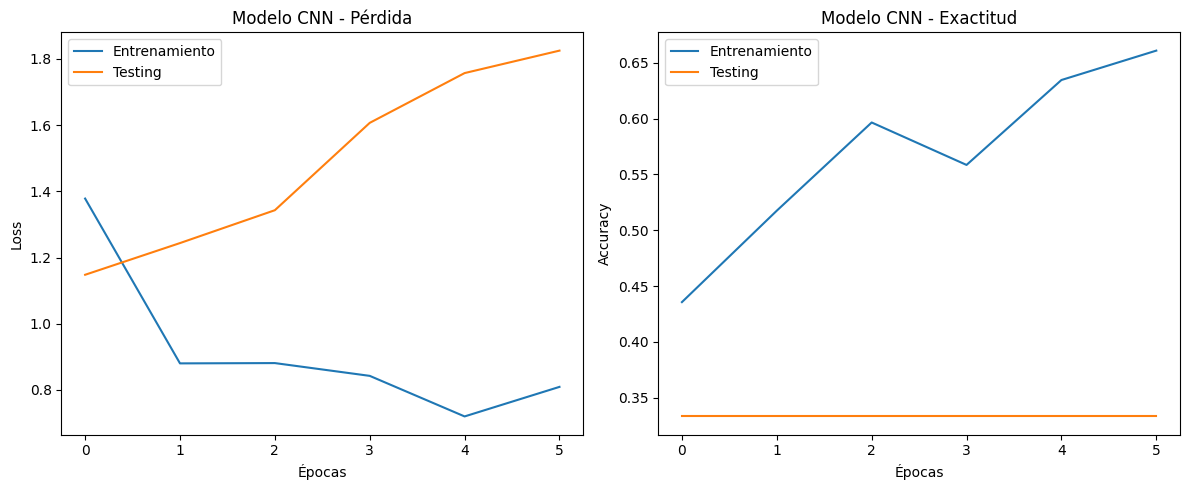

Modelo CNN - Pérdida: 1.1479, Exactitud: 0.3333


In [13]:
plot_history(history_cnn, title_prefix="Modelo CNN")
loss_cnn, acc_cnn = model_cnn.evaluate(test_generator, verbose=0)
print(f"Modelo CNN - Pérdida: {loss_cnn:.4f}, Exactitud: {acc_cnn:.4f}")
model_cnn.save('modelo_CNN.h5')

# Creación del modelo y métricas de evaluación

En esta sección se tiene que desarrollar el *pipeline* para la creación y entrenamiento de el/los modelo/s.

Se trabajará con los datos de *training* y de *validación*.

Se deberán tener en cuenta aspectos como:
- El tipo de arquitectura más adecuado para el problema
- Las métricas que se deben utilizar para medir de forma correcta el comportamiento del modelo
- Visualizaciones de las curvas de entrenamiento/validación que ayuden a decidir cuál ha sido el mejor modelo.
- Considerar un modelo *baseline* para poder comparar las métricas (por ejemplo, utilizar predicciones aleatorias o utilizar un modelo muy sencillo, como por ejemplo una red con muy pocas capas)


# Resultados y Conclusiones

En esta sección se debe implementar la fase de test de los mejores modelos desarrollados anteriormente.

Se valorarán aspectos como:
- Razonamiento de qué arquitectura es la más adecuada
- Análisis cuantitativo y cualitativo de los resultados.